# scVI on splits

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import anndata
import seaborn as sns

In [2]:
# ## import utils
# cwd = '../utils/'
# sys.path.append(cwd)

# import genes
# import panfetal_utils

In [3]:
from scIB import metrics

### Load data

In [2]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'

In [223]:
adata = sc.read_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.h5ad'.format(d=data_dir, t=timestamp))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [224]:
## Load obs
adata_obs = pd.read_csv('{d}PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.csv'.format(d=data_dir, t=timestamp),
                       index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [225]:
adata.obs = adata_obs

In [227]:
adata

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample'
    var: 'GeneID', 'GeneName'

### Load results from scVI

In [228]:
def load_scvi_outs(adata, emb_file):
    X_scVI_emb = np.load(emb_file)
    X_scVI_umap = np.load(emb_file.rstrip(".npy") + ".UMAP.npy")
    X_scVI_clust = pd.read_csv(emb_file.rstrip(".npy") + ".clustering.csv", index_col=0)
    adata.obsm["X_scvi"] = X_scVI_emb
    adata.obsm["X_umap"] = X_scVI_umap
    adata.obs["scvi_clusters"] = X_scVI_clust.loc[adata.obs_names]["leiden_150"].astype("category")

In [229]:
load_scvi_outs(adata, data_dir + "scVI_outs/PAN.A01.v01.entire_data_raw_count.{t}.scVI_out.7500HVGS.removeCC.removeTCRBCR.20ldims.npy".format(t=timestamp))

... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'organ' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical
... storing 'AnnatomicalPart' as categorical
... storing 'Sample' as categorical


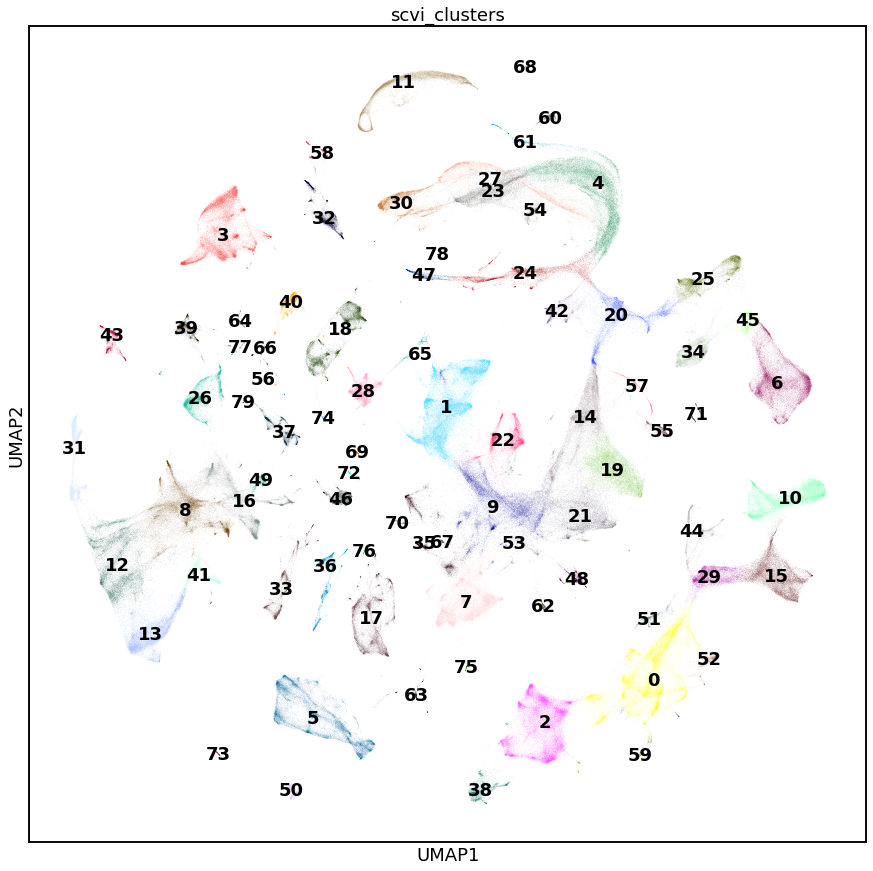

In [238]:
plt.rcParams["figure.figsize"] = [15,15]
sc.pl.umap(adata, color="scvi_clusters", legend_loc="on data")

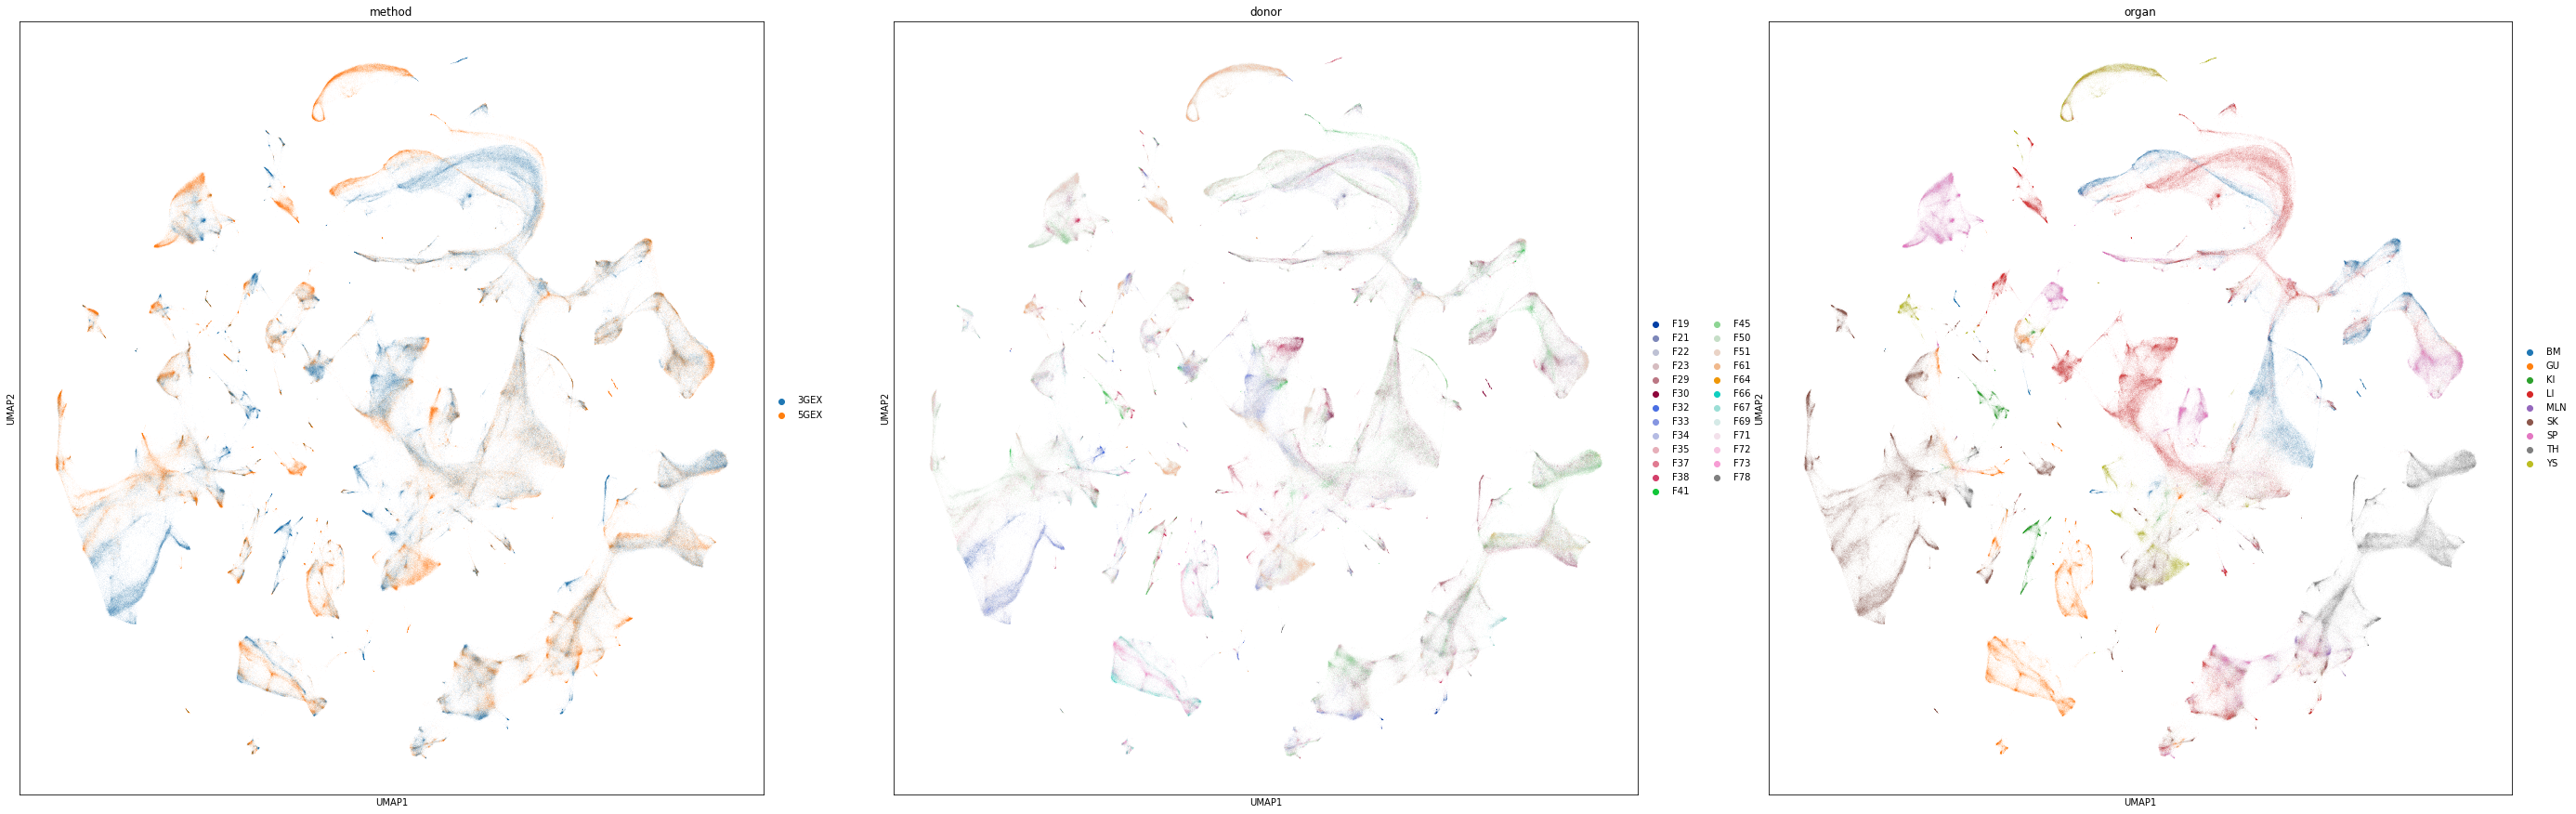

In [27]:
sc.pl.umap(adata, color=["method","donor", "organ"])

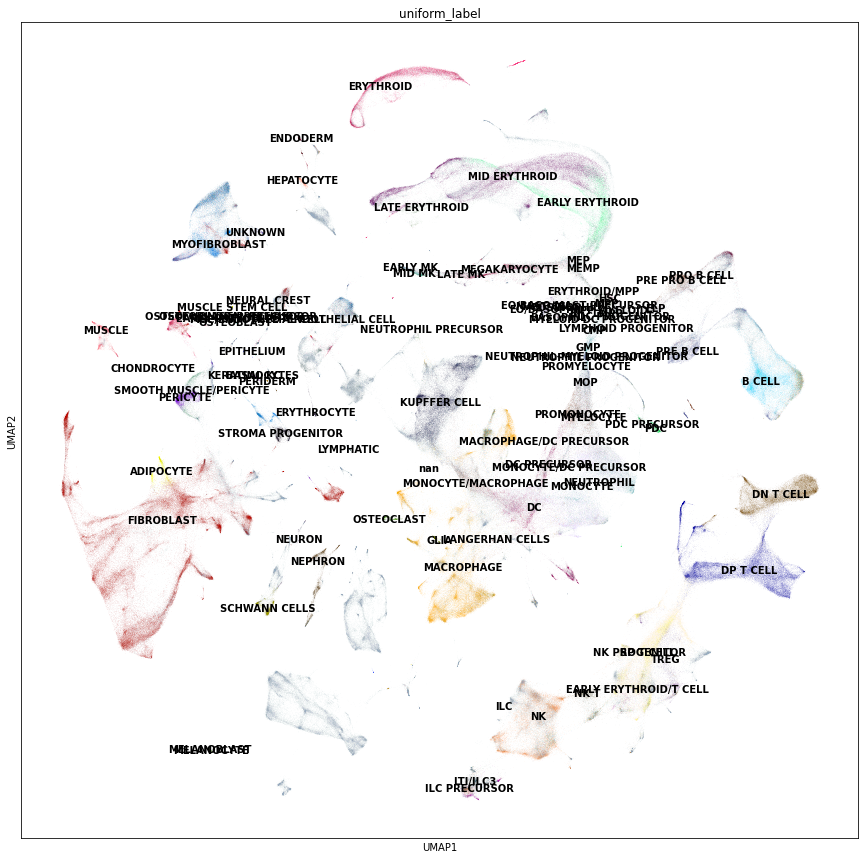

In [28]:
sc.pl.umap(adata, color=["uniform_label"], legend_loc="on data")

### Propagate labels to unannotated cells

In [239]:
def _propagate_labels(adata, anno_col):
    anno_nans = (adata.obs[anno_col]=="nan").values
    nan2labelled_conns = adata.obsp["scvi_connectivities"][:,anno_nans]
    ## Get KNN edges between nans and all cells
    nan2labelled_conns[nan2labelled_conns.nonzero()] = 1
    
    ## Make dummy matrix of labels
    lab_dummies = pd.get_dummies(adata.obs[anno_col])
    lab_unique = lab_dummies.columns
    lab = lab_dummies.to_numpy().T
    
    ## Calculate label probability based on labels of neighbours
    class_prob =  lab @ nan2labelled_conns
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    
    ## Pick label with max prob
    new_labs = lab_unique[class_prob[:,lab_unique!="nan"].argmax(1)].to_numpy()
    max_prob = class_prob[:,lab_unique!="nan"].max(1)
    new_labs[max_prob==0] = np.nan # exclude cells with no neighbour != nan

    adata.obs[anno_col + "_propagated"] = adata.obs[anno_col]
    adata.obs[anno_col + "_propagated"].loc[anno_nans] = new_labs

In [231]:
## Calculate KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

In [240]:
## Propagate labels
_propagate_labels(adata, anno_col="uniform_label")
_propagate_labels(adata, anno_col="uniform_label_lvl0")
_propagate_labels(adata, anno_col="uniform_label_expanded_merged")

### Add putative labels based on the most abundant cells in clusters

In [241]:
adata.obs["leiden_150"] = adata.obs['scvi_clusters']

In [242]:
adata.obs['leiden_150'] = [str(x) for x in adata.obs['leiden_150']]

## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_lvl0_propagated', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_lvl0_propagated']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_lvl0_propagated'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

## Add predicted uniform label based on most frequent cell type
cl_counts = adata.obs.reset_index()[["uniform_label_expanded_merged_propagated", 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', "uniform_label_expanded_merged_propagated"]) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=["uniform_label_expanded_merged_propagated"])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label_expanded'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

... storing 'leiden_150' as categorical
... storing 'leiden_150_pred_label' as categorical
... storing 'leiden_150_pred_label_expanded' as categorical


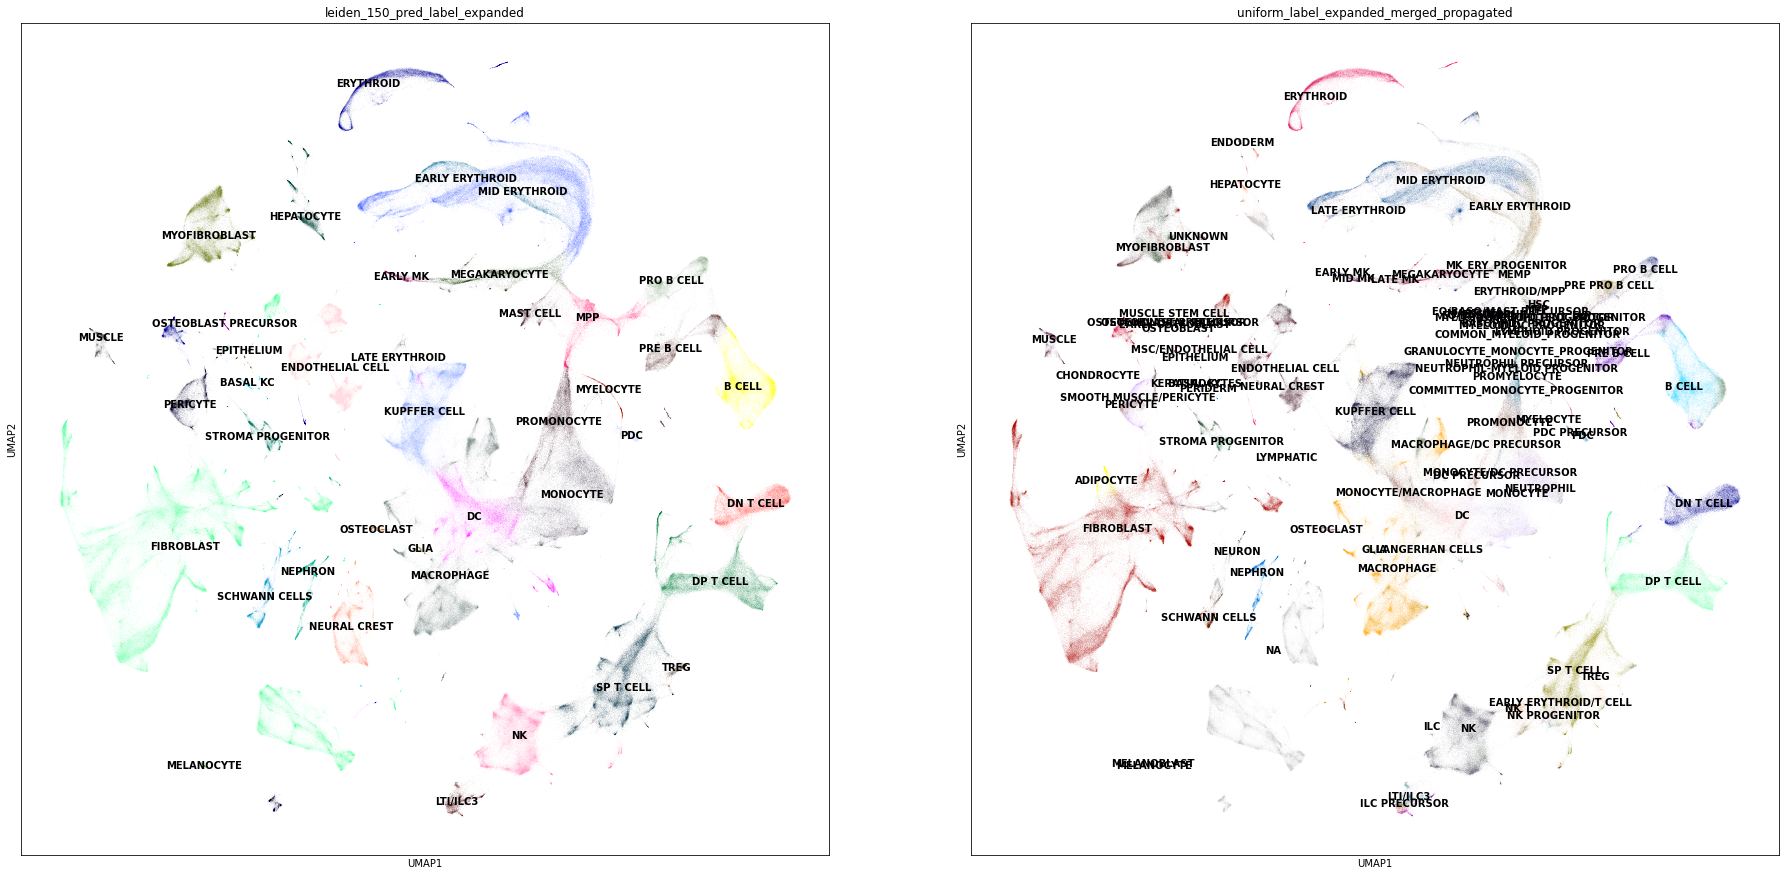

In [38]:
sc.pl.umap(adata, color=['leiden_150_pred_label_expanded',"uniform_label_expanded_merged_propagated"], legend_loc="on data")

### Putative doublet clusters

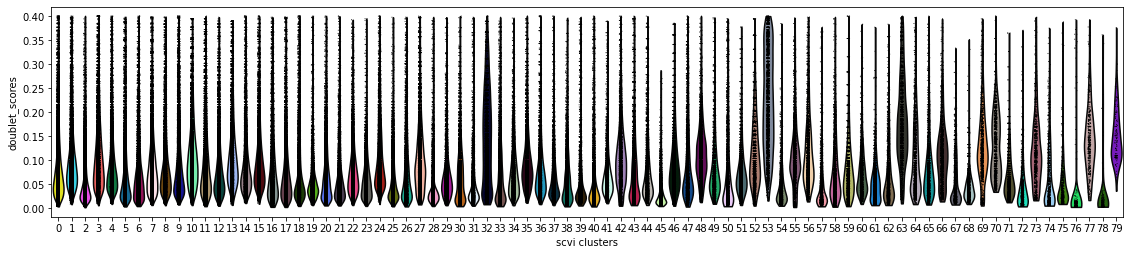

In [39]:
plt.rcParams["figure.figsize"] = [15,4]
sc.pl.violin(adata, "doublet_scores", groupby="scvi_clusters")

In [42]:
adata.obs[["doublet_scores", "scvi_clusters"]].groupby('scvi_clusters').median().sort_values("doublet_scores", ascending=False)[0:20]

doublet_scores
scvi_clusters                
53                   0.215596
63                   0.170619
32                   0.148997
79                   0.139897
77                   0.135135
70                   0.125320
69                   0.118644
73                   0.109375
48                   0.108911
66                   0.108036
52                   0.103093
56                   0.098927
10                   0.094828
42                   0.094675
55                   0.094675
3                    0.090909
13                   0.090722
27                   0.088608
64                   0.083906
35                   0.081917

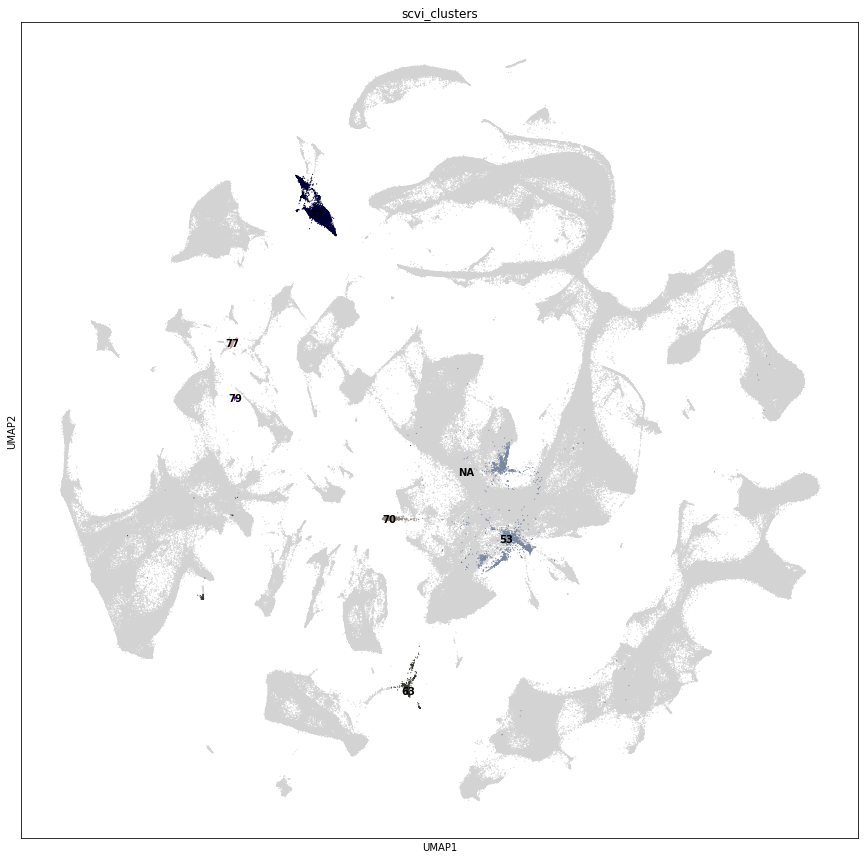

In [44]:
doub_clusters = np.where(adata.obs[["doublet_scores", "scvi_clusters"]].groupby('scvi_clusters').median() > 0.12)[0]
plt.rcParams["figure.figsize"] = [15,15]
sc.pl.umap(adata, color="scvi_clusters", groups=list(doub_clusters), legend_loc="on data", size=5)

### Visualize cluster purity

In [ ]:
cl_counts = cl_counts.fillna(0).sort_values(cl_counts.columns[0])
cl_counts.columns = ["Cluster" + str(y) for x,y in cl_counts.columns]
cl_fracs = cl_counts/cl_counts.sum(0)

In [ ]:
celltype_order = cl_counts.idxmax(0).sort_values().unique()
celltype_order = np.concatenate([celltype_order, cl_counts.index[~cl_counts.index.isin(celltype_order)].values])
cluster_order = cl_counts.idxmax(0).sort_values().index

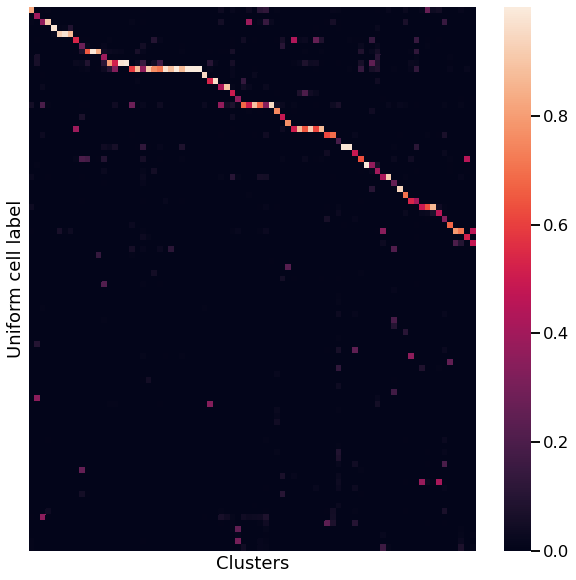

In [49]:
import matplotlib
sns.set_context("talk")
plt.rcParams["figure.figsize"] = [10,10]
sns.heatmap(cl_fracs.loc[celltype_order, cluster_order], xticklabels=False, yticklabels=False);
plt.xlabel("Clusters");
plt.ylabel("Uniform cell label");
plt.savefig("/home/jovyan/PFI_clustering.pdf", bbox_inches="tight")

## Define data subsets

In [243]:
# ## import splitting rules
# cwd = '../3_clustering/'
# sys.path.append(cwd)
# import splitting_rules
splitting_labels = {}

In [244]:
anno_unif = adata.obs[["uniform_label_expanded_merged","uniform_label_lvl0"]].drop_duplicates()
hsc_immune_lvl0 = ["LYMPHOID", "MYELOID", "HSC_MPP", "MEGAKARYOCYTE", "ERYTHROID", "EO_BASO_MAST"]
splitting_labels["STROMA"] = anno_unif["uniform_label_expanded_merged"][~anno_unif["uniform_label_lvl0"].isin(hsc_immune_lvl0)].values
splitting_labels["HSC_IMMUNE"] = anno_unif["uniform_label_expanded_merged"][anno_unif["uniform_label_lvl0"].isin(hsc_immune_lvl0)].values

In [245]:
splitting_labels["LYMPHOID"] = anno_unif["uniform_label_expanded_merged"][anno_unif["uniform_label_lvl0"].isin(["LYMPHOID", "HSC_MPP"])].values.tolist()
splitting_labels["MYELOID"] = anno_unif["uniform_label_expanded_merged"][anno_unif["uniform_label_lvl0"].isin(["MYELOID", "HSC_MPP", "EO_BASO_MAST"])].values.tolist()
splitting_labels["MYELOID_LYMPHOID"] = splitting_labels["LYMPHOID"] + splitting_labels["MYELOID"]

## Exclude PDC clusters from single view
splitting_labels["LYMPHOID"] = [x for x in splitting_labels["LYMPHOID"] if 'PDC' not in x]
splitting_labels["MYELOID"] = [x for x in splitting_labels["MYELOID"] if 'PDC' not in x]

In [255]:
splitting_labels["MEM_PROGENITORS"] = [x for x in splitting_labels["HSC_IMMUNE"] if x not in splitting_labels["MYELOID_LYMPHOID"]]

In [246]:
adata.obs["isin_STROMA"] = adata.obs["leiden_150_pred_label_expanded"].isin(splitting_rules.splitting_labels["STROMA"])
adata.obs["isin_HSC_IMMUNE"] = adata.obs["leiden_150_pred_label_expanded"].isin(splitting_rules.splitting_labels["HSC_IMMUNE"])
adata.obs["isin_STROMA"] = adata.obs["isin_STROMA"].astype("category")
adata.obs["isin_HSC_IMMUNE"] = adata.obs["isin_HSC_IMMUNE"].astype("category")

... storing 'leiden_150' as categorical
... storing 'leiden_150_pred_label' as categorical
... storing 'leiden_150_pred_label_expanded' as categorical


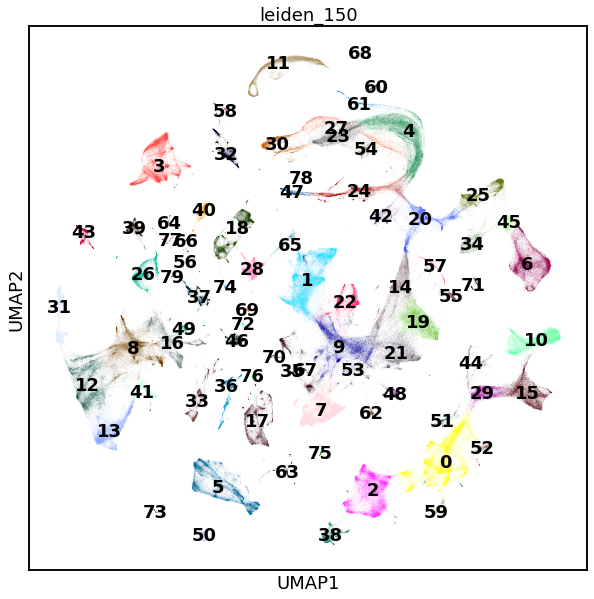

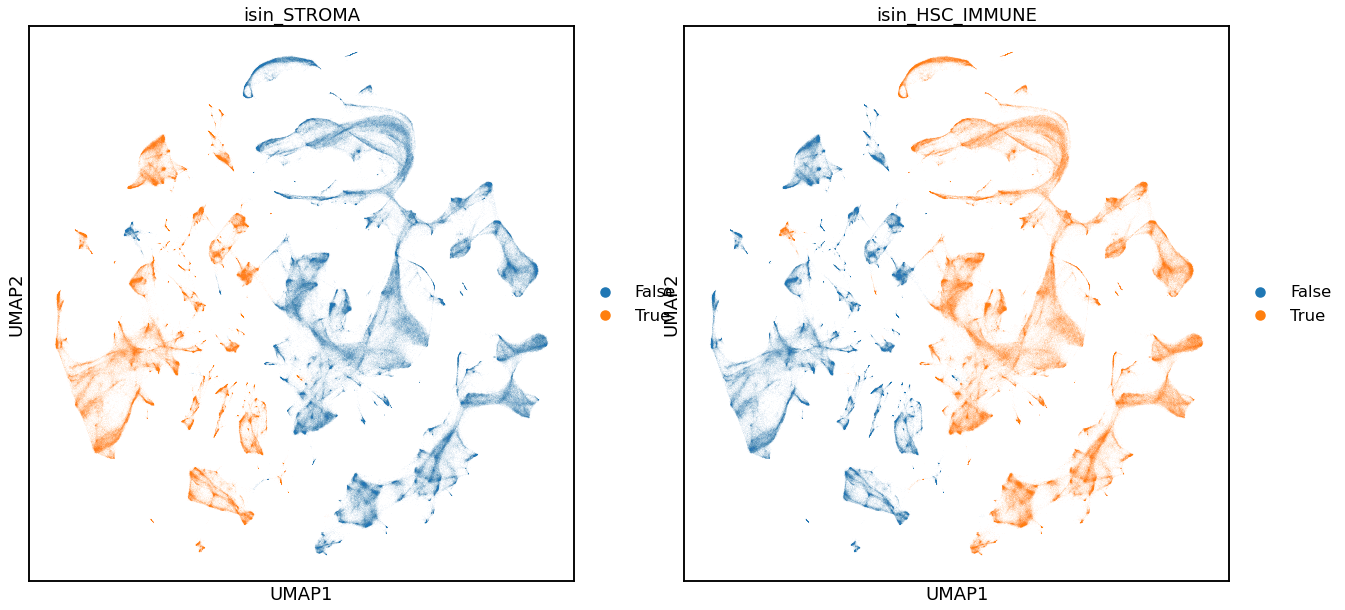

In [207]:
sc.pl.umap(adata, color=["leiden_150"], legend_loc="on data")
sc.pl.umap(adata, color=["isin_STROMA", "isin_HSC_IMMUNE"])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


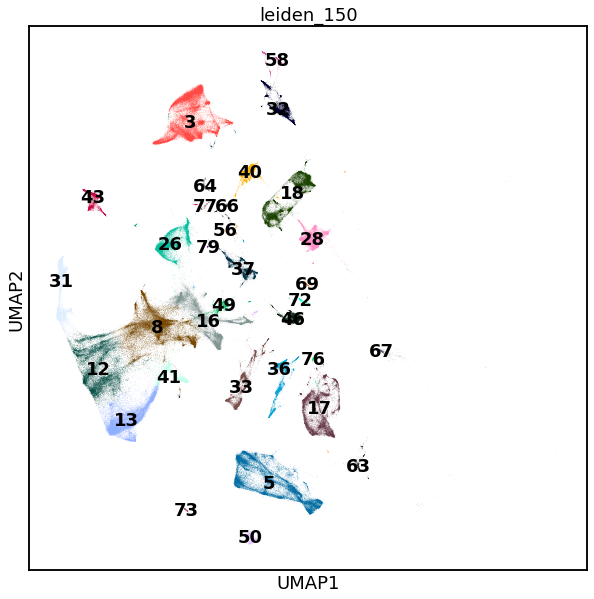

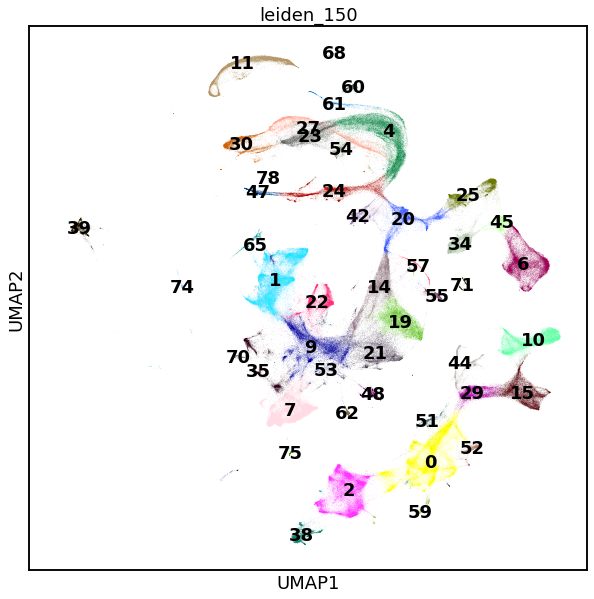

In [208]:
sc.pl.umap(adata[adata.obs["isin_STROMA"] == True], color=["leiden_150"], legend_loc="on data")
sc.pl.umap(adata[adata.obs["isin_HSC_IMMUNE"] == True], color=["leiden_150"], legend_loc="on data")

Some clusters that look odd but are not odd:
- glial clusters (67/33) are assigned to Stroma (Schwann cells and microglia)
- Cluster 39 and 74 are erythroid (might get filtered later)

In [256]:
for k in splitting_labels.keys():
    adata.obs["isin_" + k] = adata.obs["leiden_150_pred_label_expanded"].isin(splitting_labels[k])
    adata.obs["isin_" + k] = adata.obs["isin_" + k].astype("category")

In [248]:
# del adata.obs["isin_B"] 
# del adata.obs["isin_NKT"] 

In [257]:
split_cols = [x for x in adata.obs.columns if x.startswith("isin")]

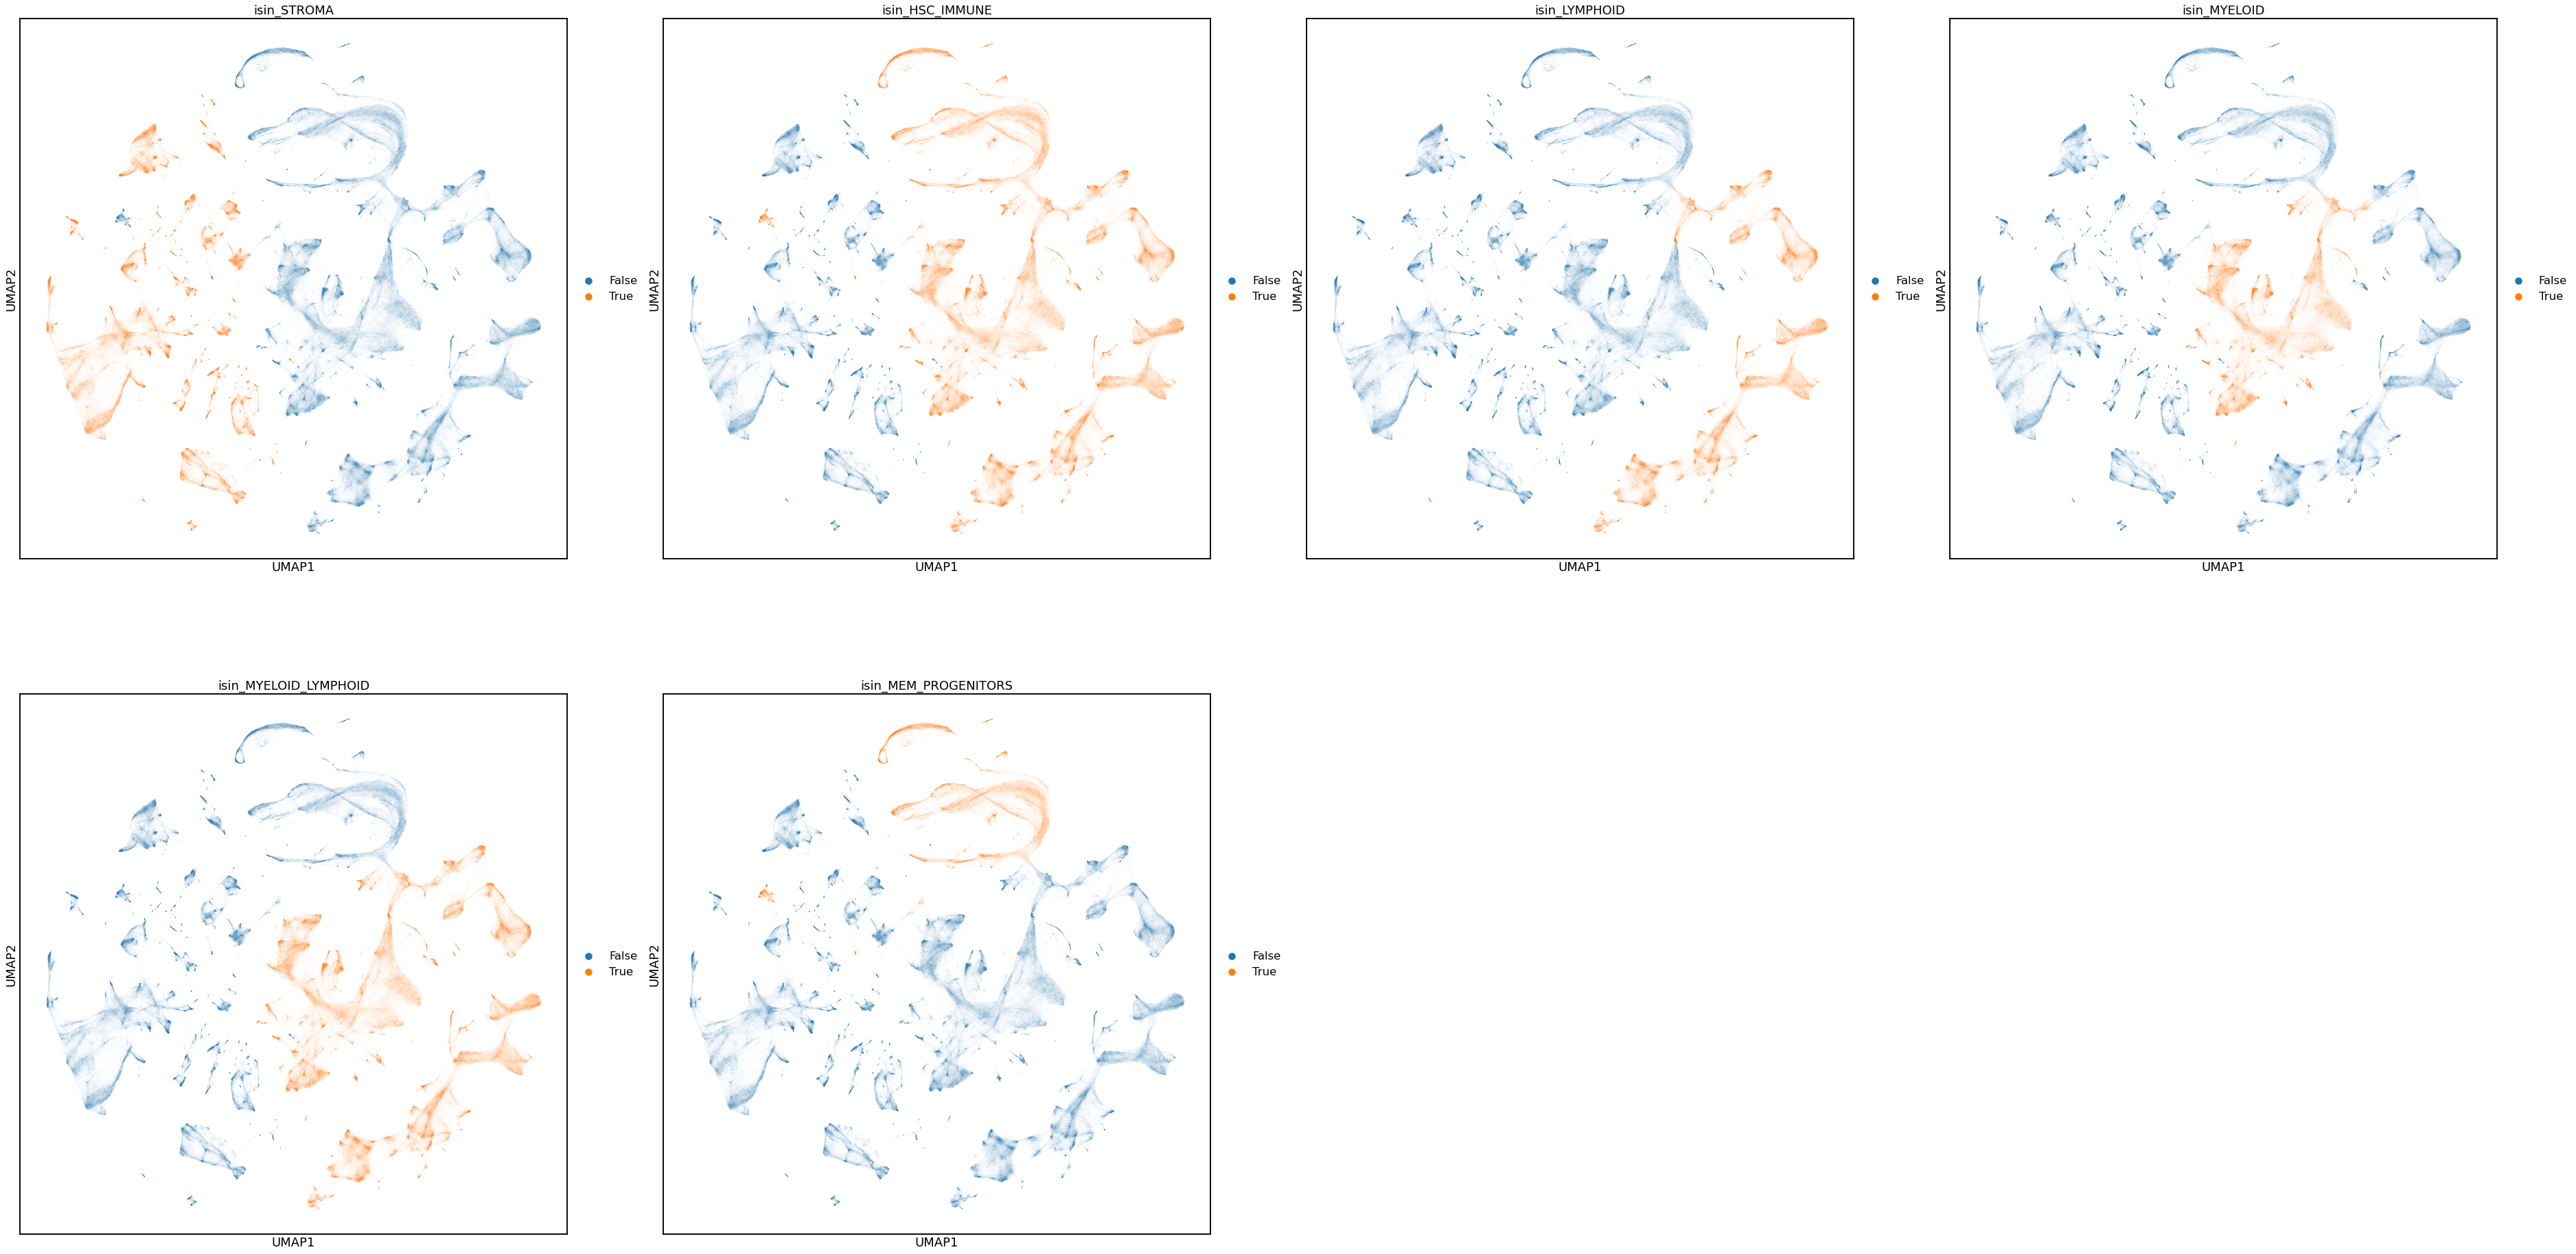

In [258]:
sc.pl.umap(adata, color=split_cols)

### Save adatas of splits (for scVI)

In [214]:
adata_raw = sc.read_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.h5ad'.format(d=data_dir, t=timestamp))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [251]:
adata_raw

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name'
    var: 'GeneID', 'GeneName'

In [254]:
for s in splitting_labels.keys():
#     if s != "STROMA":
    sdata = adata[adata.obs["isin_" + s]==True]
    sdata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))
    sdata_raw = adata_raw[adata.obs["isin_" + s]==True] 
    sdata_raw.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))

In [259]:
s = "MEM_PROGENITORS"
sdata = adata[adata.obs["isin_" + s]==True]
sdata.write_h5ad('{d}PAN.A01.v01.entire_data_normalised_log.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))
sdata_raw = adata_raw[adata.obs["isin_" + s]==True] 
sdata_raw.write_h5ad('{d}PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(d=data_dir, t=timestamp, s=s))